In [1]:
import os
from utils.configuration import *
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "api_ordinal_multi_simple_4"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists/home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/configuration.json


In [4]:
# import numpy as np
# import pandas as pd
# from sklearn.datasets import make_classification

# # Generate synthetic data for logistic regression
# X, y = make_classification(
#     n_samples=100_000,      # number of samples
#     n_features=1,       # one predictor
#     n_informative=1,    # the predictor is informative
#     n_redundant=0,      # no redundant features
#     n_clusters_per_class=3,
#     class_sep=1.5,      # separation between classes
#     weights=[0.9, 0.1],  # 90% class 0, 10% class 1
#     random_state=42
# )

# # Convert to DataFrame for convenience
# df = pd.DataFrame({'x': X.flatten(), 'y': y})

# # Save or inspect
# print(df.head())


import numpy as np
import pandas as pd

# Generate one continuous predictor
n = 100_000
x = np.random.normal(0, 1, n)
x1 = np.random.normal(2, 4, n)
x2 = np.random.normal(-1, 1, n)
x3 = np.random.normal(3, 0.1, n)

# Define thresholds for 4 ordered levels
thresholds = [-0.8, 0.0, 0.8]

# Digitize x into 4 ordinal levels (0,1,2,3)
y = np.digitize(x, thresholds)

# Combine into DataFrame
df = pd.DataFrame({'x': x,'x1': x1,'x2': x2,'x3': x3, 'y': y})

print(df.head())
print(df['y'].value_counts(normalize=True))


          x        x1        x2        x3  y
0 -0.021610 -1.406189 -0.660431  2.794733  1
1  0.711346  3.082843 -1.881319  3.000531  2
2 -0.588906 -0.950687 -0.311783  2.884128  1
3 -0.202301 -1.652841 -0.773311  3.038284  1
4 -1.165257  0.781868 -2.241324  3.040077  0
y
1    0.28927
2    0.28891
0    0.21195
3    0.20987
Name: proportion, dtype: float64


In [5]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [6]:
train_df.to_csv(os.path.join(EXPERIMENT_DIR, "train.csv"), index=False)

In [7]:
data_type={'x':'continous','x1':'continous','x2':'continous','x3':'continous','y':'ordinal_Xn_Yo'}
data_type

{'x': 'continous',
 'x1': 'continous',
 'x2': 'continous',
 'x3': 'continous',
 'y': 'ordinal_Xn_Yo'}

In [8]:
write_data_type_to_configuration(data_type, CONF_DICT_PATH)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x                    | continous       | continuous [c]                 | continuous [c]                
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | continous       | continuous [c]                 | continuous [c]                
y                    | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
---------------------------------------------------------

/home/bule/TramDag/utils/configuration.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


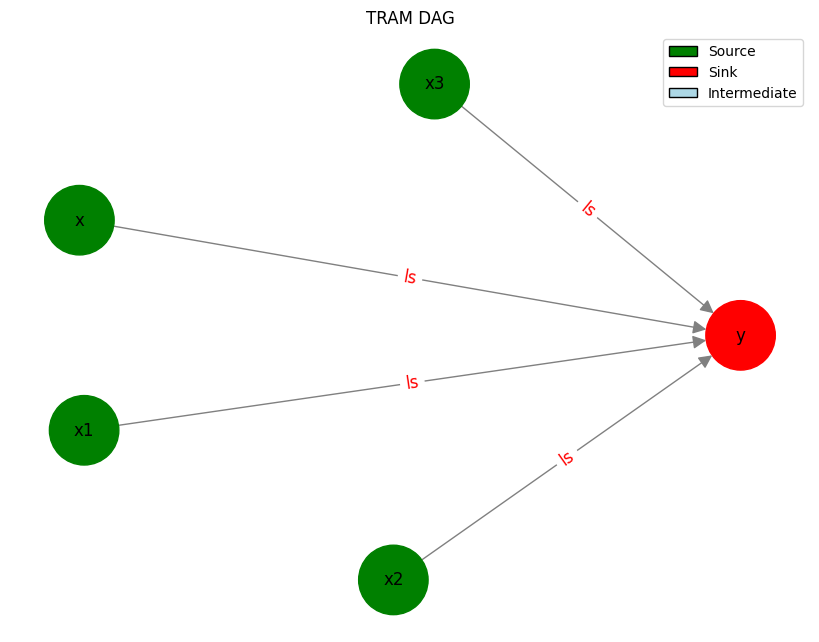

In [9]:
interactive_adj_matrix(CONF_DICT_PATH,seed=19)

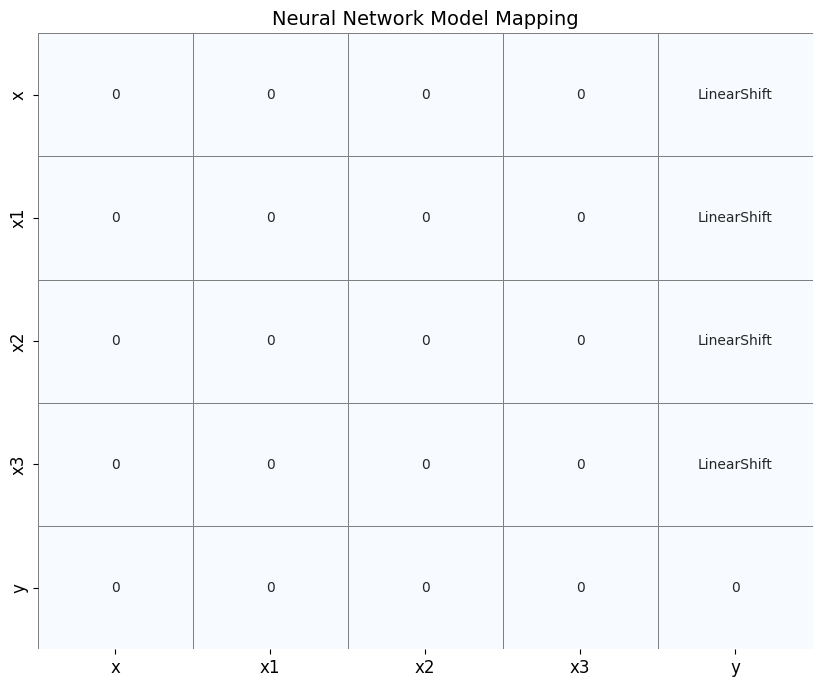

In [10]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [11]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load(f"/home/bule/TramDag/dev_experiment_logs/{experiment_name}/configuration.json")
cfg.compute_levels(train_df)
device='cpu'

In [12]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=True,verbose=True,debug=True,device=device,initial_data = train_df) 
# 1m52s

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'x' with settings: {'set_initial_weights': True, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':               x        x1        x2        x3  y
75220 -0.821872 -2.259700 -1.624256  2.905394  0
48955  0.544478  2.061223 -1.741761  2.898447  2
44966 -0.931215  0.701049 -0.868408  2.997679  0
13568 -1.494289  0.946689  0.760300  3.018228  0
92727  2.066425  1.914214 -1.472373  3.086642  3
...         ...       ...       ...       ... ..
6265   2.116803  0.301601  0.196171  3.014315  3
54886 -0.787758  1.375930 -0.244545  2.962603  1
76820 -0.934636  8.043723  0.135433  3.122809  0
860    1.772592  0.762044 -0.025250  3.277614  3
15795  1.322881  0.770267 -2.252637  2.959018  3

[80000 rows x 5 columns]}
[DEBUG] get_fully_specified_tram_model(): device: cpu
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Wrote DataFrame to temporary CSV: temp/initial_data_1761252464.csv
[DEBUG] R scr

In [12]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-2,
             epochs=500,batch_size=1_000,
             verbose=True,debug=False,
             device=device,
             save_linear_shifts=True,
             save_simple_intercepts=True,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

#30 eps 1m 49s seq mode from start 1000 bs
#30 eps 2m 27s parllel multiprocessing mode from start 1000 bs
# 200 eps 9m 30s seq mode from start 1000 bs

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/min_max_scaling.json
[INFO] Training 5 nodes (sequential) on cpu

[INFO] Training node 'x' for 500 epochs on cpu (pid=1013116)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'x1' for 500 epochs on cpu (pid=1013116)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'x2' for 500 epochs on cpu (pid=1013116)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'x3' for 500 epochs on cpu (pid=1013116)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'y' for 500 epochs on cpu (pid=1013116)
[INFO] Existing model found. Loading weights and history...


[INFO] Loaded training/validation histories for 5 nodes.


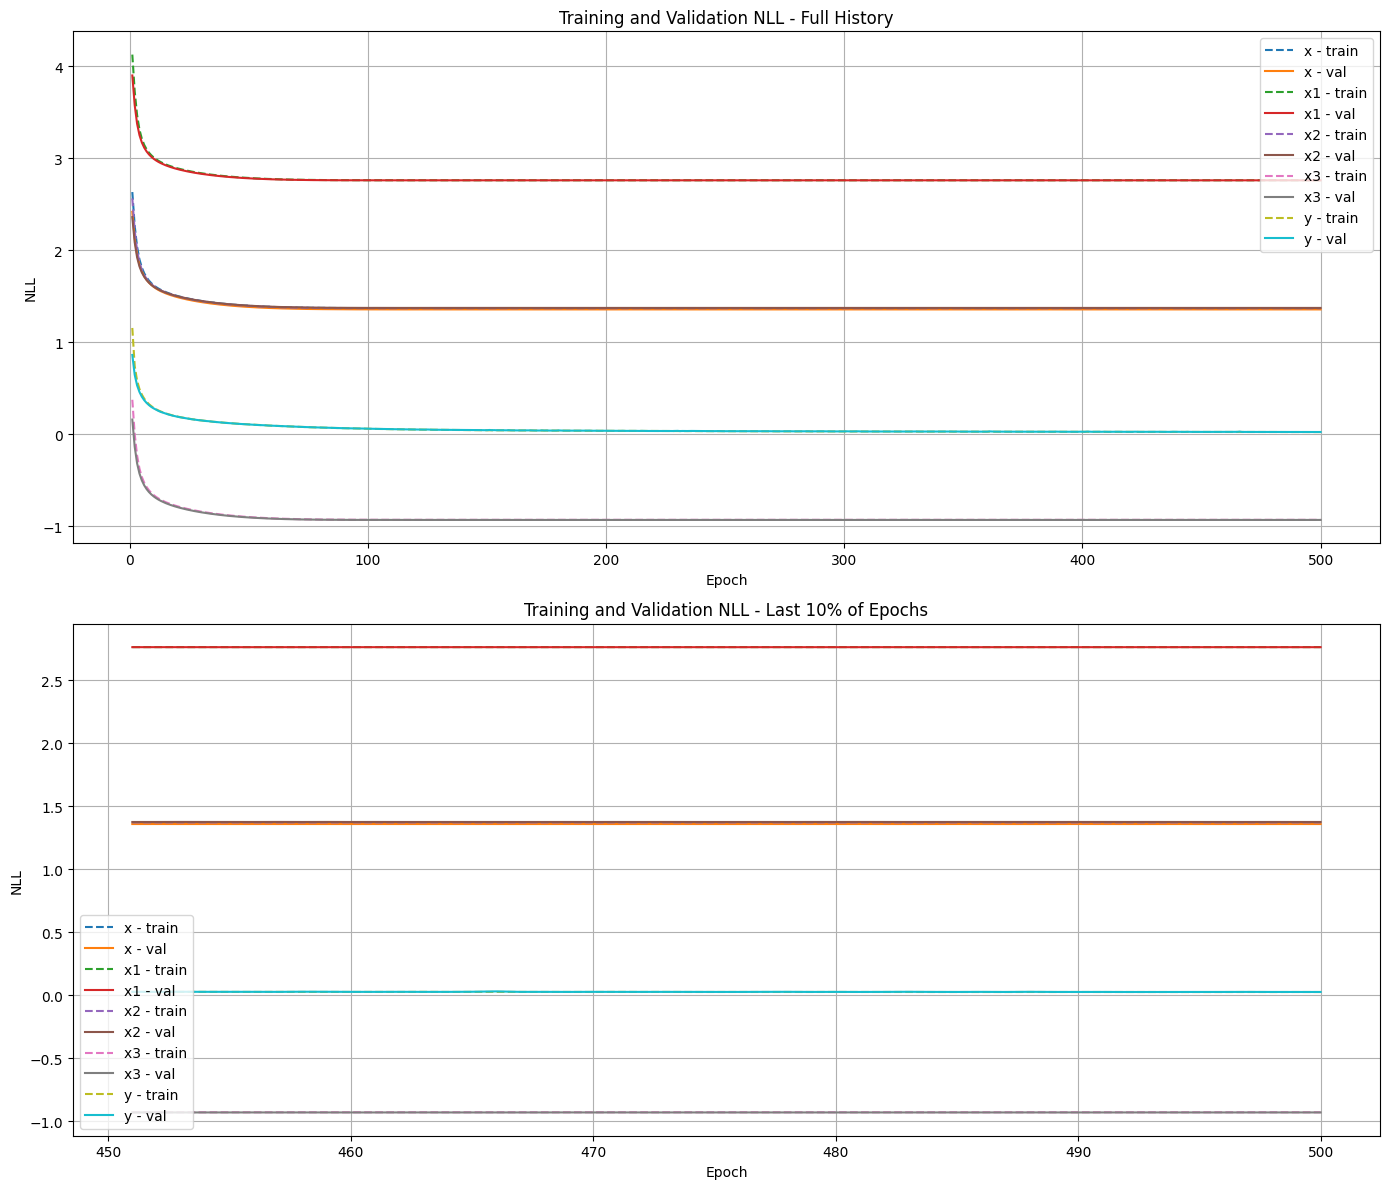

In [13]:
td_model.plot_loss_history()

[WARNING] No linear shift history found for node 'x' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'x1' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x1/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'x2' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x2/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'x3' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x3/linear_shifts_all_epochs.json


/home/bule/TramDag/utils/tramdag.py:1569: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


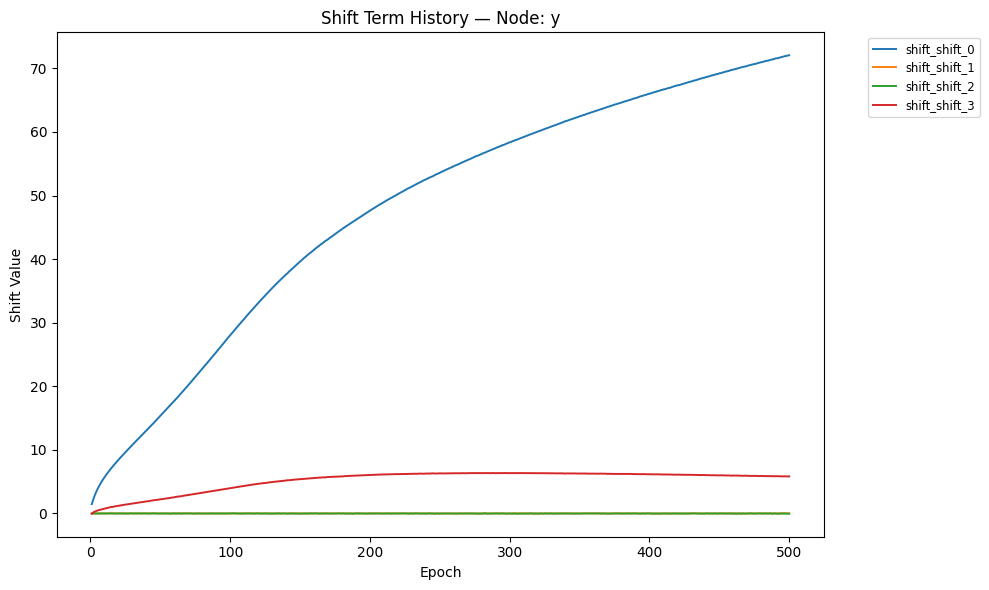

In [ ]:
td_model.plot_shift_histories()

/home/bule/TramDag/utils/tramdag.py:1618: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


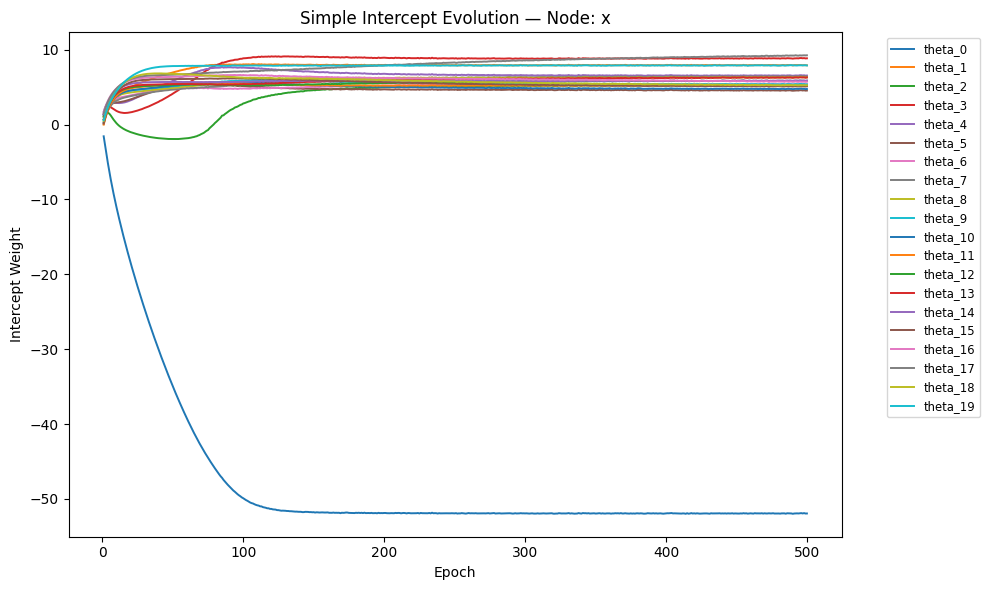

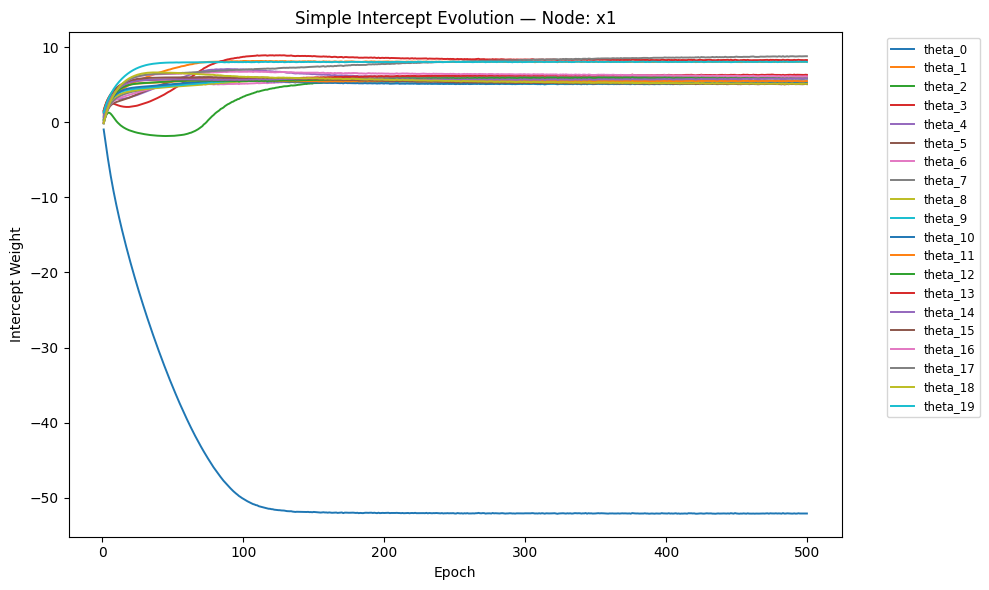

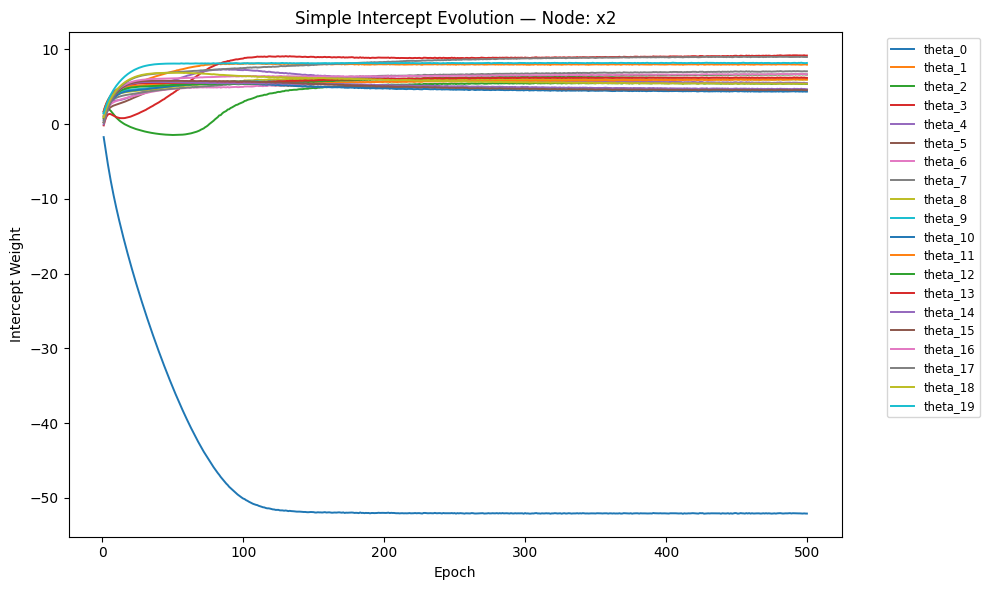

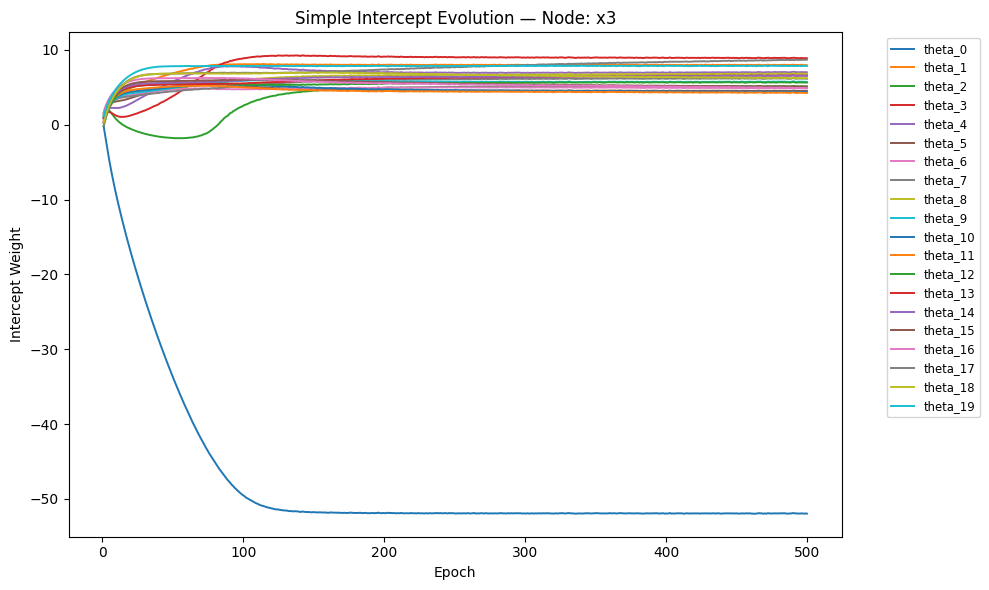

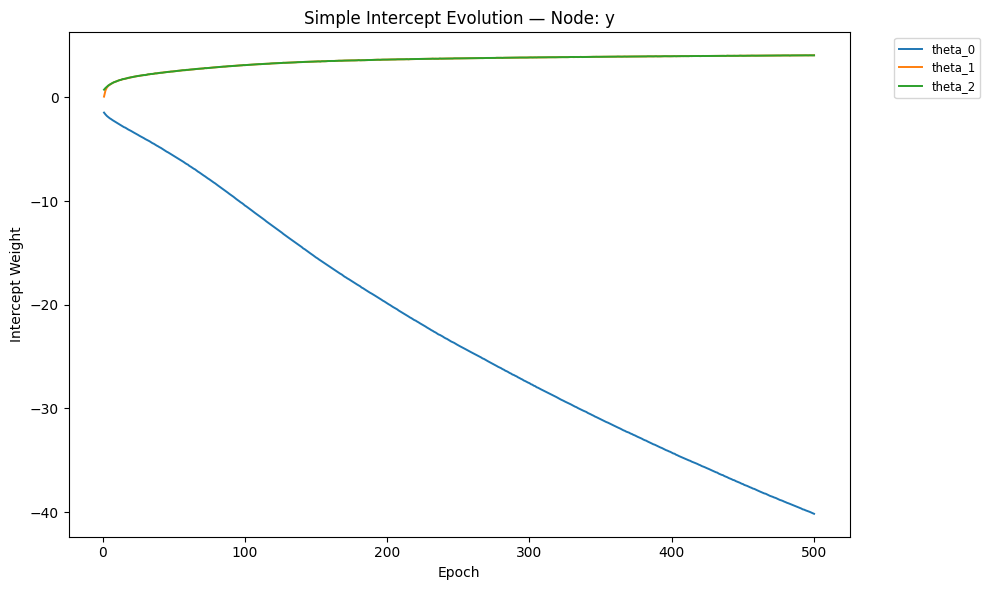

In [15]:
td_model.plot_simple_intercepts()

In [16]:
td_model.load_or_compute_minmax(td_train_data=train_df)
rsamples, latents = td_model.sample(use_initial_weights_for_sampling=True)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/min_max_scaling.json
[DEBUG] sample(): device: cpu
[INFO] Starting full DAG sampling with 10000 samples per node.
[DEBUG] sample_full_dag: device: cpu
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x3/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/y/sampling

----*----------*-------------*--------Sample Node: x ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x from standard logisti

[DEBUG] sample_continous_modelled_target: source node, defaults to SI and 1 as inputs
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 205.63it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x'

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cpu
[DEBUG] default_number_thetas for continuous outcomes: 20
[INFO] Using initial weights for sampling for node 'x1'
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 'x1' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x', 'x1', 'x2', 'x3', 'y']
[DEBUG] Set parents_datatype_dict: type=<class 'collections.OrderedDict'>, keys=[]
[DEBUG] Set transformation_terms_preprocessing: type=<class 'list'>, value=[]
[DEBUG] Set predictors: type=<class '

[DEBUG] sample_continous_modelled_target: source node, defaults to SI and 1 as inputs
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 193.55it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cpu
[DEBUG] default_number_thetas for continuous outcomes: 20
[INFO] Using initial weights for sampling for node 'x2'
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 'x2' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x', 'x1', 'x2', 'x3', 'y']
[DEBUG] Set parents_datatype_dict: type=<class 'collections.OrderedDict'>, keys=[]
[DEBUG] Set transformation_terms_preprocessing: type=<class 'list'>, value=[]
[DEBUG] Set predictors: type=<class 

[DEBUG] sample_continous_modelled_target: source node, defaults to SI and 1 as inputs
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 204.41it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cpu
[DEBUG] default_number_thetas for continuous outcomes: 20
[INFO] Using initial weights for sampling for node 'x3'
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 'x3' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x', 'x1', 'x2', 'x3', 'y']
[DEBUG] Set parents_datatype_dict: type=<class 'collections.OrderedDict'>, keys=[]
[DEBUG] Set transformation_terms_preprocessing: type=<class 'list'>, value=[]
[DEBUG] Set predictors: type=<class 

[DEBUG] sample_continous_modelled_target: source node, defaults to SI and 1 as inputs
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 211.04it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x3'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[DEBUG] check_sampled_and_latents: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x/sampling
[DEBUG] check_sampled_and_latents: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x/sampling
[DEBUG] check_sampled_and_latents: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x1/sampling
[DEBUG] check_sampled_and_latents: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x1/sampling
[DEBUG] check_sampled_and_latents: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/api_ordinal_multi_simple_4/x2/sampling
[DEBUG] check_sampled_and_latents: Found 'latents.pt' in /home/bule/TramDag/dev

[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 3])
[DEBUG] shift_out shapes: [torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 1])]
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 3])
[DEBUG] shift_out shapes: [torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 1])]
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 3])
[DEBUG] shift_out shapes: [torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 1])]
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 3])
[DEBUG] shift_out shapes: [torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 1])]
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size(

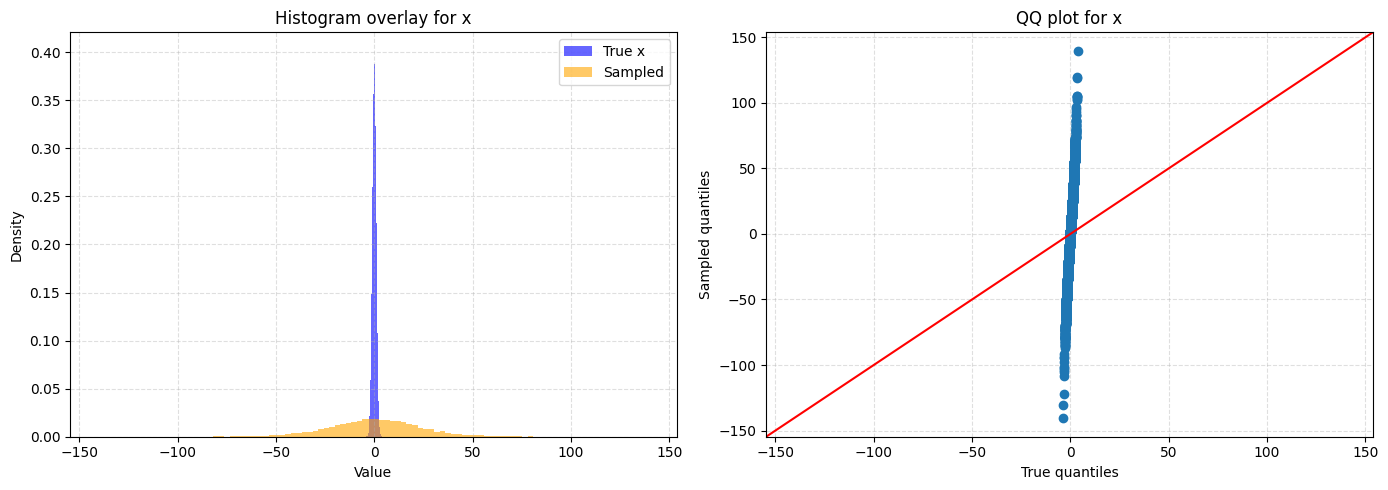

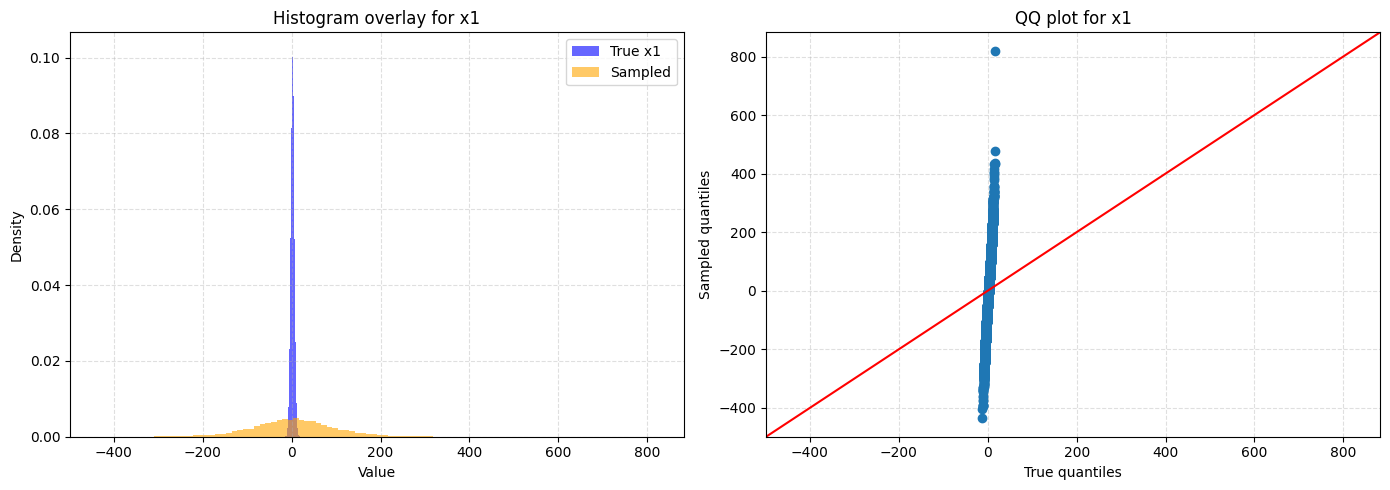

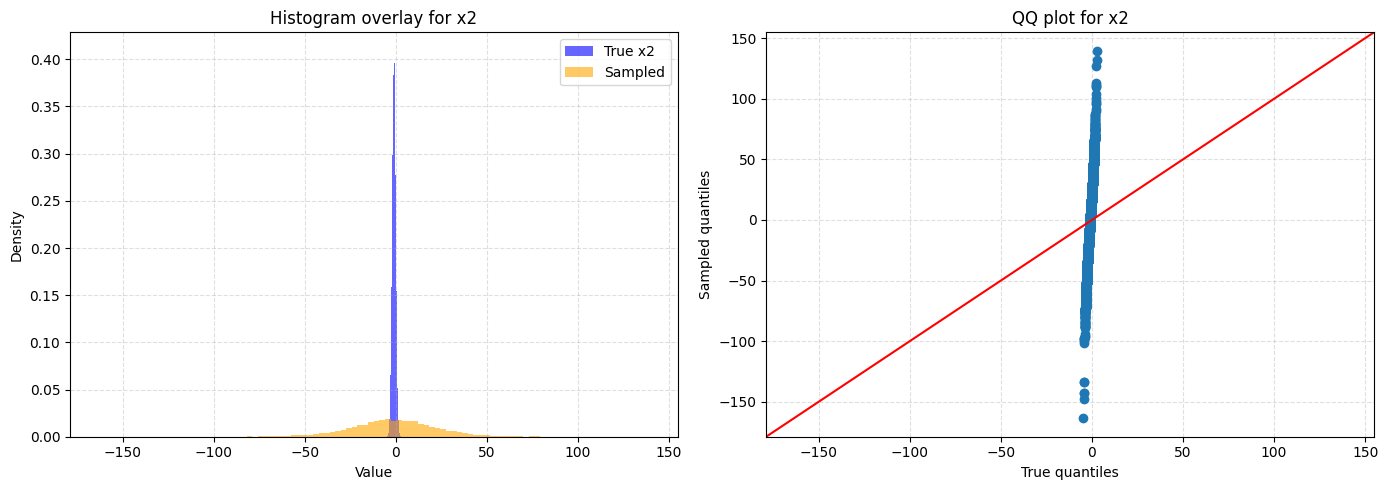

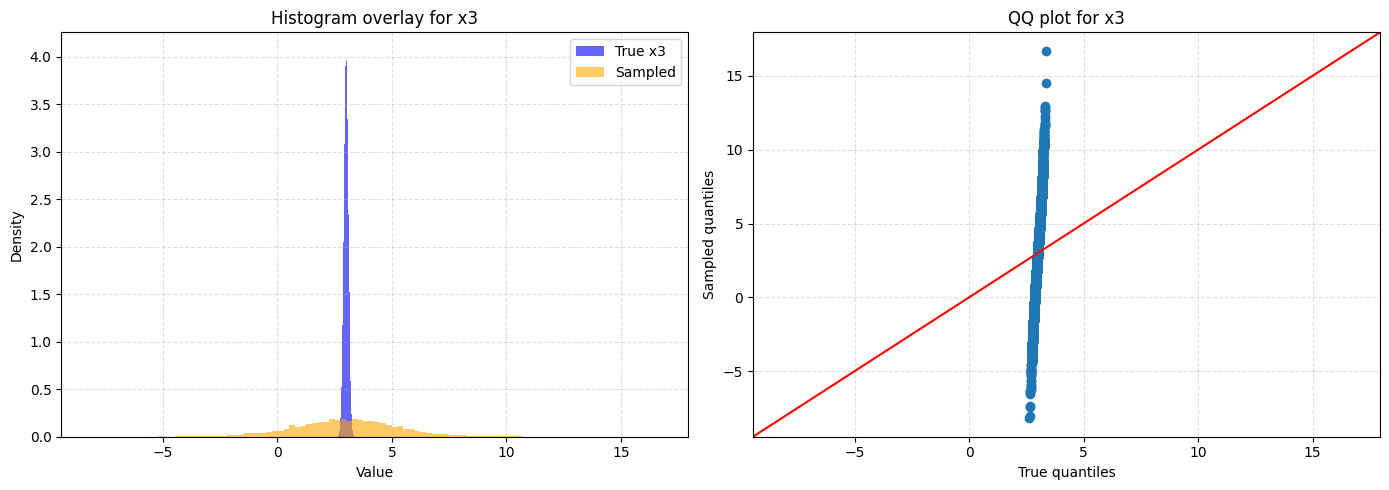

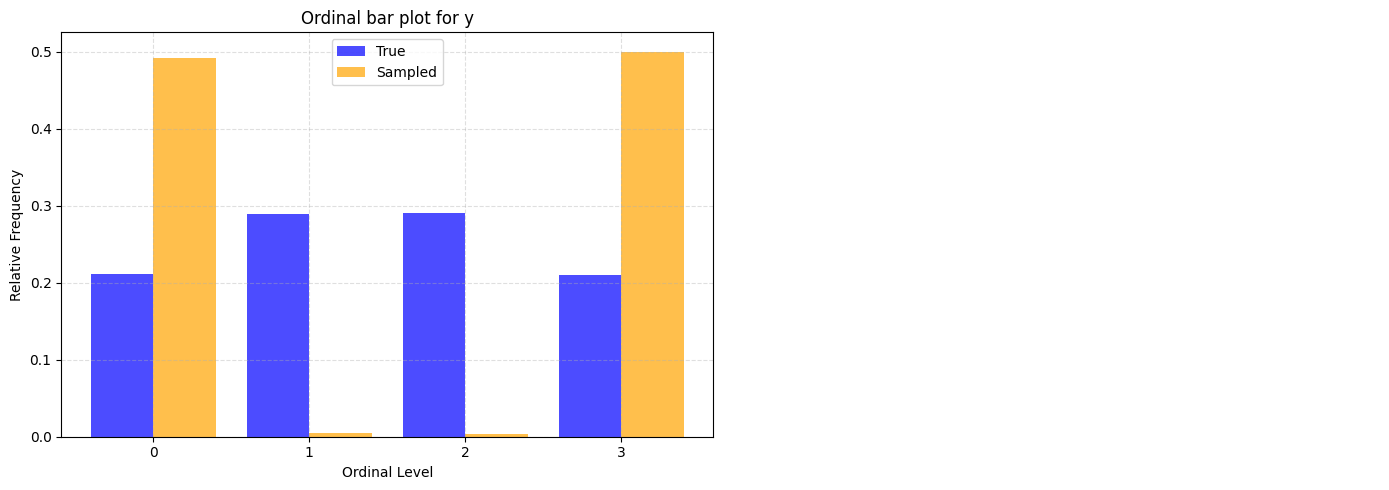

In [17]:
td_model.show_samples_vs_true(train_df)